In [1]:
import sys
sys.path.insert(0, '../code/')
from dismod_db import DismodDB
from two_level import TwoLevel
from plot_two_level import PlotTwoLevel
import numpy as np
import pandas as pd
from dismod_output import DismodOutput

#### Build database

In [2]:
data = pd.read_csv('./data/diabetes_sinc_1000_loc_cov.csv')

In [3]:
data.head()

,Unnamed: 0,Unnamed: 0.1,location_id,X,sex,age_start,age_end,year_start,year_end,mean,standard_error,measure,ow,bmi,fpg,location_name,region_name
0,0,1,8,913,Female,60,99.000,2001,2002,0.000010,0.000100,Sincidence,0.367407,23.525415,5.884486,Taiwan,East Asia
1,1,2,8,441,Female,45,59.000,2005,2006,0.000010,0.000100,Sincidence,0.434376,23.969006,5.534053,Taiwan,East Asia
2,2,3,8,464,Male,0,0.999,2016,2016,0.000000,0.000012,prevalence,0.000000,25.215980,0.000000,Taiwan,East Asia
3,3,4,8,375,Male,15,29.000,2007,2008,0.000031,0.000100,Sincidence,0.327989,24.704975,1.826869,Taiwan,East Asia
4,4,5,8,956,Male,15,29.000,2001,2002,0.000032,0.000100,Sincidence,0.265633,23.871868,1.606499,Taiwan,East Asia


In [4]:
integrand = ['Sincidence']
locations = ['Australia', 'New Zealand']
rates = ['iota']
meas_noise_density = {'Sincidence': {'density': 'gaussian'}}
rates_parent_priors = [
    # rate priors for iota
    ({'density':'uniform','upper':1.0,'lower':1e-16,'mean': .01},\
    {'density': 'gaussian', 'mean':0.0, 'std': .3},\
    {'density': 'gaussian', 'mean':0.0, 'std': .1})]
rates_child_priors = [
    # rate priors for iota
    ({'density':'gaussian','mean': 0.0, 'std': 1},\
    {'density': 'gaussian', 'mean':0.0, 'std': 1},\
    {'density': 'gaussian', 'mean':0.0, 'std': 1})]
covariates = [{'name':'bmi','type': 'rate_value','effected': 'iota'},
             {'name': 'ow', 'type': 'rate_value', 'effected': 'iota'}]
cov_priors = [{'density':'uniform','mean': 0.0}, {'density':'uniform','mean': 0.0}]
#---------change path------------
path_to_db = './data/incidence_two_level_cov.db'

db = DismodDB(data, locations, integrand,rates, rates_parent_priors, 
              rates_child_priors, meas_noise_density, path_to_db, covariates=covariates, cov_priors=cov_priors)

#### Train model

In [5]:
model = TwoLevel(db)

In [6]:
model.fit_both(tol=1e-10, max_iter=200)

/home/prefix/dismod_at.release/bin/dismod_at ./data/incidence_two_level_cov.db init
./data/incidence_two_level_cov.db fit fixed
./data/incidence_two_level_cov.db predict fit_var
./data/incidence_two_level_cov.db set start_var fit_var
./data/incidence_two_level_cov.db fit both
./data/incidence_two_level_cov.db predict fit_var


#### Plots

In [7]:
path = './data/'
plt = PlotTwoLevel(path, 'incidence_two_level_cov.db')

{1: 'Australia', 2: 'New Zealand', 0: 'all'}


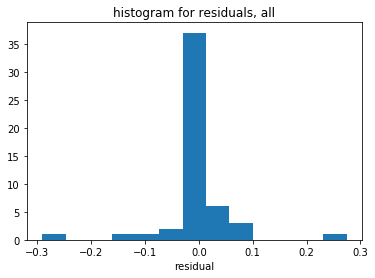

In [8]:
plt.plot_residuals('all')

In [9]:
output = DismodOutput(path_to_db)
output.get_covariate_multiplier_values(['bmi', 'ow'])

{1: 'Australia', 2: 'New Zealand', 0: 'all'}


,covariate_name,fit_var_value
2,bmi,-0.113284
3,ow,2.084408


In [10]:
location_name_to_id = {}
for i, row in data[data['location_name'].isin(locations)].iterrows():
    location_name_to_id[row['location_name']] = row['location_id']
    if len(location_name_to_id) == len(locations):
        break
print(location_name_to_id)
output.save_GBD_output(['Sincidence', 'prevalence'], list(range(1980, 2019)), [1], location_name_to_id, './data/incidence_cov_gbd_sample.csv')

{'Australia': 71, 'New Zealand': 72}
./data/incidence_two_level_cov_gbd.db
[[0.0, 'Sincidence'], [0.0, 'prevalence']]
./data/incidence_two_level_cov_gbd.db predict fit_var


In [11]:
df = pd.read_csv('./data/incidence_cov_gbd_sample.csv')

In [12]:
df[['location_id', 'age_group_id', 'sex_id', 'year_id', 'measure_id', 'mean', 'lower', 'upper']]

,location_id,age_group_id,sex_id,year_id,measure_id,mean,lower,upper
0,71,2,1,1985,41,0.001988,0.001988,0.001988
1,72,2,1,1985,41,0.002176,0.002176,0.002176
2,71,2,1,1986,41,0.001967,0.001967,0.001967
3,72,2,1,1986,41,0.002153,0.002153,0.002153
4,71,2,1,1987,41,0.001947,0.001947,0.001947
5,72,2,1,1987,41,0.002131,0.002131,0.002131
6,71,2,1,1988,41,0.001927,0.001927,0.001927
7,72,2,1,1988,41,0.002109,0.002109,0.002109
8,71,2,1,1989,41,0.001478,0.001478,0.001478
9,72,2,1,1989,41,0.001617,0.001617,0.001617


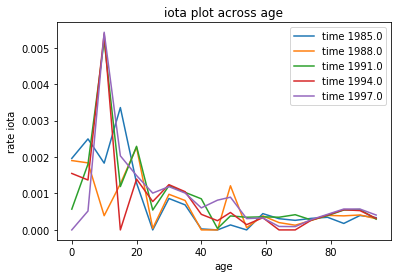

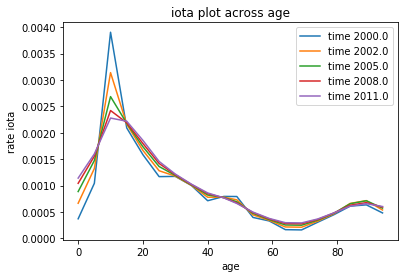

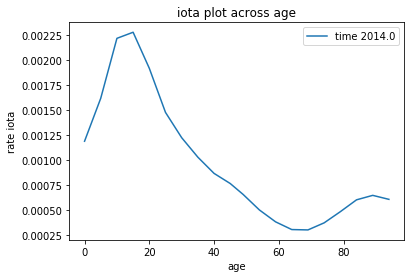

In [13]:
plt.plot_change_over_age('rate', 'iota', 'Sincidence', 'all', plot_data=False)

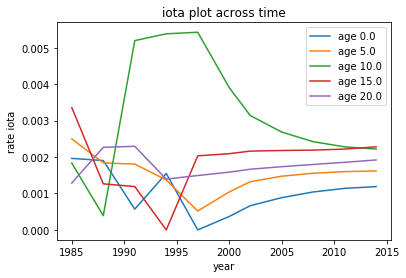

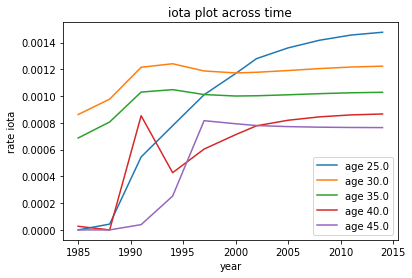

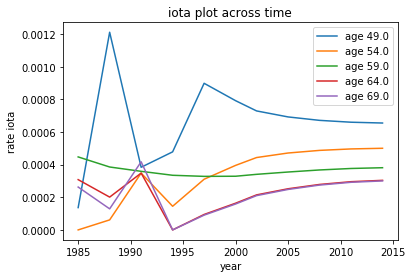

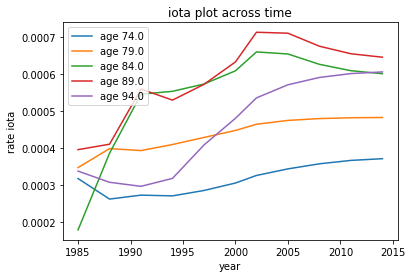

In [14]:
plt.plot_change_over_time('rate', 'iota', 'Sincidence', 'all', plot_data=False)